# 3.6 Reconciling projections

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#3.6-Reconciling-projections" data-toc-modified-id="3.6-Reconciling-projections-1">3.6 Reconciling projections</a></span><ul class="toc-item"><li><span><a href="#3.6.1-Introduction" data-toc-modified-id="3.6.1-Introduction-1.1">3.6.1 Introduction</a></span></li><li><span><a href="#3.6.2-Requirements" data-toc-modified-id="3.6.2-Requirements-1.2">3.6.2 Requirements</a></span><ul class="toc-item"><li><span><a href="#3.6.2.1-Get-the-MODIS-LAI-datasets-for-2016/2017-for-W.-Europe" data-toc-modified-id="3.6.2.1-Get-the-MODIS-LAI-datasets-for-2016/2017-for-W.-Europe-1.2.1">3.6.2.1 Get the MODIS LAI datasets for 2016/2017 for W. Europe</a></span></li><li><span><a href="#3.6.2.2-Get-the-shapefile-for-country-borders" data-toc-modified-id="3.6.2.2-Get-the-shapefile-for-country-borders-1.2.2">3.6.2.2 Get the shapefile for country borders</a></span></li><li><span><a href="#3.6.2.3-Read-the-LAI-dataset-for-a-given-country-and-year" data-toc-modified-id="3.6.2.3-Read-the-LAI-dataset-for-a-given-country-and-year-1.2.3">3.6.2.3 Read the LAI dataset for a given country and year</a></span></li><li><span><a href="#3.6.2.4-register-with-ECMWF-and-install-the-API" data-toc-modified-id="3.6.2.4-register-with-ECMWF-and-install-the-API-1.2.4">3.6.2.4 register with ECMWF and install the API</a></span></li><li><span><a href="#3.6.2.4-Get-the-2t-dataset-from-ECMWF-for-Europe" data-toc-modified-id="3.6.2.4-Get-the-2t-dataset-from-ECMWF-for-Europe-1.2.5">3.6.2.4 Get the 2t dataset from ECMWF for Europe</a></span></li></ul></li><li><span><a href="#3.6.3-Reconcile-the-datasets" data-toc-modified-id="3.6.3-Reconcile-the-datasets-1.3">3.6.3 Reconcile the datasets</a></span><ul class="toc-item"><li><span><a href="#3.6.3.1-load-an-exemplar-dataset" data-toc-modified-id="3.6.3.1-load-an-exemplar-dataset-1.3.1">3.6.3.1 load an exemplar dataset</a></span></li><li><span><a href="#3.6.3.2-get-information-from-source-file" data-toc-modified-id="3.6.3.2-get-information-from-source-file-1.3.2">3.6.3.2 get information from source file</a></span></li><li><span><a href="#3.6.3.3-deal-with-netcdf-projection" data-toc-modified-id="3.6.3.3-deal-with-netcdf-projection-1.3.3">3.6.3.3 deal with netcdf projection</a></span></li><li><span><a href="#3.6.3.4-reprojection" data-toc-modified-id="3.6.3.4-reprojection-1.3.4">3.6.3.4 reprojection</a></span></li><li><span><a href="#3.6.3.5-crop" data-toc-modified-id="3.6.3.5-crop-1.3.5">3.6.3.5 crop</a></span></li><li><span><a href="#3.6.3.6-metadata" data-toc-modified-id="3.6.3.6-metadata-1.3.6">3.6.3.6 metadata</a></span></li></ul></li><li><span><a href="#3.6.4-Putting-this-together" data-toc-modified-id="3.6.4-Putting-this-together-1.4">3.6.4 Putting this together</a></span></li></ul></li></ul></div>

## 3.6.1 Introduction

This section of notes is optional to the course, and the tutor may decide *not* to go through this in class. That said, the information and obexamples contained here can be very useful for accessing and processing certain types of geospatial data.

In particular, we deal with obtaining climate data records from [ECMWF](http://apps.ecmwf.int/datasets/data/era40-daily/levtype=sfc) that we will later use for model fitting. These data come in a [netcdf](https://confluence.ecmwf.int/display/CKB/What+are+NetCDF+files+and+how+can+I+read+them) format (commonly used for climate data) with a grid in latitude/longitude. To 'overlay' these data with another dataset (e.g. the MODIS LAI product that we have been using) in a different (equal area) projection, we use the `gdal` function

    gdal.ReprojectImage(src, dst, src_proj, dst_proj, interp)
       
where:

    src      : a source dataset that we want to process 
    dst      : a blank destination dataset that we set up with the 
               required (output) data type, shape, and geotransform and projection
    src_proj : the source dataset projection wkt 
    dst_proj : the destination projection wkt 
    interp   : the required interpolation method, e.g. gdalconst.GRA_Bilinear
    
where wkt stands for [well known text](https://en.wikipedia.org/wiki/Well-known_text) and is a projection format string.

Other codes we use are ones we have developed earlier.

In these notes, we will learn:

    * how to access an ECMWF daily climate dataset (from ERA interim)
    * how to reproject the dataset to match another spatial dataset (MODIS LAI)
    
We will then save some datasets that we will use later in the notes. For this reason, it's possile to skip this section, and return to it later.

## 3.6.2 Requirements

We will need to:

* make sure we have the MODIS LAI dataset locally
* read them in for a given country.
* register with ecmwf, install ecmwfapi
* get the temperature datasset from ECMWF for 2006 and 2017 for Europe
* get the country borders shapefile

In [1]:
# required general imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys
import os
from pathlib import Path
import gdal
from datetime import datetime, timedelta

### 3.6.2.1 Get the MODIS LAI datasets for 2016/2017 for W. Europe

You will probably already have this dataset, but running the code below will make sure that you do.

In [2]:
# get the MODIS LAI dataset for 2016/2017 for W. Europe
from geog0111.geog_data import procure_dataset
from pathlib import Path

files = list(Path('data').glob('MCD15A3H.A201[6-7]*h1[7-8]v0[3-4].006*hdf'))
if len(files) < 732:
    _ = procure_dataset("lai_files",verbose=False)

### 3.6.2.2 Get the shapefile for country borders

Again, you should already have this, but just to make sure:

In [3]:
import requests
import shutil
from pathlib import Path

force = False
# zip file
zipfile = 'TM_WORLD_BORDERS-0.3.zip'
# URL
tm_borders_url = f"http://thematicmapping.org/downloads/{zipfile}"
# destibnation folder
destination_folder = Path('data')

# set up some filenames
zip_file = destination_folder.joinpath(zipfile)
shape_file = zip_file.with_name(zipfile.replace('zip', 'shp'))

# download zip if need to
if not Path(zip_file).exists():
    r = requests.get(tm_borders_url)
    with open(zip_file, 'wb') as fp:
        fp.write(r.content)

# extract shp from zip if need to
if force or not Path(shape_file).exists():
    shutil.unpack_archive(zip_file.as_posix(), extract_dir=destination_folder)
    

### 3.6.2.3 Read the LAI dataset for a given country and year

Run the code below to read in the LAI dataset for a given year and country. This uses codes we have developed in previous sections, interfaced through `process_timeseries()`.

In the code, we can save the dataset as an `npz` file, so that we can access it faster next time. If you don't want to use disk space to do that however, simply set `save = False` below.

In [4]:
# read in the LAI data for given country code
from geog0111.process_timeseries import process_timeseries
'''
Note, the saved npz file can be quite large
e.g. 8.1 G for France.

You can override saving it by setting save = False
but if it is saved, it will be faster to access
data the next time you need it.

If you have a slow network, you might set download=False
'''
country_code = 'UK'
year = 2017
save = True
download = True

tiles = []
for h in [17, 18]:
    for v in [3, 4]:
        tiles.append(f"h{h:02d}v{v:02d}")
        
fname = f'lai_data_{year}_{country_code}.npz'
ofile = Path('data')/fname
done = False

if ofile.exists():
    done = True
    
# try to download it from server
if download:
    done = procure_dataset(fname,verbose=True)
    
if not done:
    # else generate it
    dates, lai_array, weights_array = process_timeseries(year,tiles,\
                                                     country_code=country_code)
    lai = {'dates':dates, 'lai':lai_array, 'weights':weights_array}
    if save:
        np.savez(ofile,**lai)
        
if done:
    # else read it from npz file
    lai = np.load(ofile)

### 3.6.2.4 register with ECMWF and install the API

First, you should [register as a user with ECMWF](https://apps.ecmwf.int/auth/login).

The first time:

* register and follow the emailed instructions.

* read and acknowledge the [conditions of access and related information](https://www.ecmwf.int/en/computing/access-computing-facilities/conditions-access-ecmwf-computing-services).

* follow the instructions on [how to access datasets](https://confluence.ecmwf.int/display/WEBAPI/Access+ECMWF+Public+Datasets) to receive and set up [an ECMWF key](https://confluence.ecmwf.int/display/WEBAPI/Access+ECMWF+Public+Datasets#AccessECMWFPublicDatasets-key)

Help is available [online](https://confluence.ecmwf.int/display/UDOC/User+Documentation).

In [5]:
# install ecmwf api -- do this once only
try:
    from ecmwfapi import ECMWFDataServer
except:
    !cd data/ecmwf; python setup.py install --user

### 3.6.2.4 Get the 2t dataset from ECMWF for Europe

Run the code below to request and download the daily 2m temperature dataset for 2016 and 2017 (0.25 degree resolution) from the ECMWF ERA interim data.

If the file already exists locally, the request will be ignored.

If you do need to run the request, it may take several hours, depending on the ECMWF queue at the time.

In [6]:
from ecmwfapi import ECMWFDataServer
from pathlib import Path
from geog0111.geog_data import procure_dataset

ofile = 'europe_data_2016_2017.nc'
if not (Path('data')/ofile).exists():
    # try to get it from UCL servers
    done = procure_dataset(ofile,verbose=True)
    if not done:
        server = ECMWFDataServer()
        print('requesting data ... may take some time')
        server.retrieve({
            "class": "ei",
            "dataset": "interim",
            "date": "2016-01-01/to/2017-12-31", # Time period
            "expver": "1",
            "levtype": "sfc",
            "param": "2t",           # Parameters. Here we use 2m Temperature (2t)  See the ECMWF parameter database, at http://apps.ecmwf.int/codes/grib/param-db
            "stream": "oper",
            "type": "an",
            "time": "12",
            "step": "0",
            "area": "75/-20/10/60",    # Subset or clip to an area, here to Europe. Specify as North/West/South/East in Geographic lat/long degrees. Southern latitudes and Western longitudes must be given as negative numbers.
            "grid": "0.25/0.25",        # Regrid from the default grid to a regular lat/lon with specified resolution. The first number is east-west resolution (longitude) and the second is north-south (latitude).
            "format": "netcdf",         # Convert the output file from the default GRIB format to NetCDF format. Requires "grid" to be set to a regular lat/lon grid.
            "target": f"data/{ofile}",  # The output file name. Set this to whatever you like.
        })
else: print(f'{ofile} exists')

europe_data_2016_2017.nc exists


## 3.6.3 Reconcile the datasets

### 3.6.3.1 load an exemplar dataset

Since we want to match up datasets, we need to produce an example of the dataset we want to match up to.

We save the exemplar as a GeoTiff format file here.

data/Lai_500m_2017_001_LU.tif


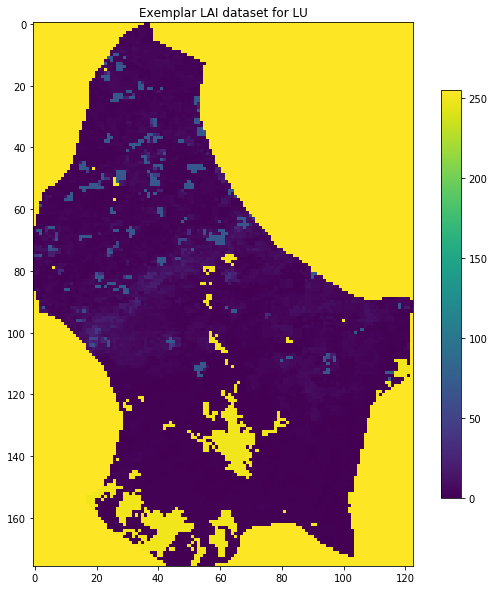

In [7]:
from osgeo import gdal, gdalconst,osr
import numpy as np
from geog0111.process_timeseries import mosaic_and_clip


country_code = 'LU'
shpfile = "data/TM_WORLD_BORDERS-0.3.shp"

'''
https://stackoverflow.com/questions/10454316/
how-to-project-and-resample-a-grid-to-match-another-grid-with-gdal-python
'''
        
# first get an exemplar LAI file, clipped to
# the required limits. We will use this to match  
# the t2 dataset to
match_filename = mosaic_and_clip(tiles,1,2017,\
                    country_code=country_code,shpfile=shpfile,frmat='GTiff')

print(match_filename)

'''
Now get the projection, geotransform and dataset
size that we want to match to
'''
match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly)
match_proj = match_ds.GetProjection()
match_geotrans = match_ds.GetGeoTransform()
wide = match_ds.RasterXSize
high = match_ds.RasterYSize

plt.figure(figsize=(10,10))
plt.title(f'Exemplar LAI dataset for {country_code}')
plt.imshow(match_ds.ReadAsArray())
plt.colorbar(shrink=0.75)
# close the file -- we dont need it any more
del match_ds

### 3.6.3.2 get information from source file


Now, we pull the information we need from the source file (the netcdf format t2 dataset).

We need to know:

* the data type
* the number of bands (time samples in this case)
* the geotransform of the dataset (the fact that it's 0.25 degree resolution over Europe)

and access these from the source dataset.



/Users/plewis/anaconda/envs/geog0111/lib/python3.6/site-packages/matplotlib/transforms.py:2902: RuntimeWarning: overflow encountered in short_scalars
  elif vmax - vmin <= maxabsvalue * tiny:


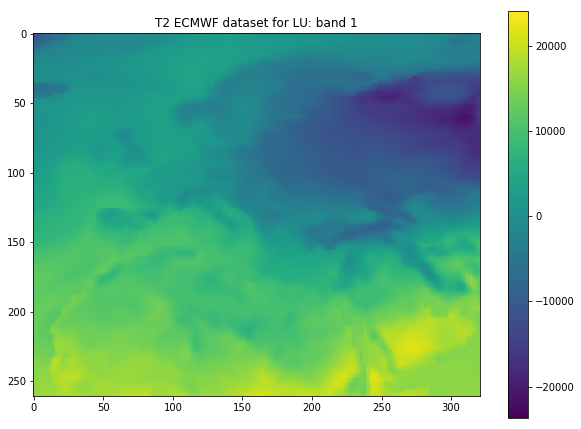

In [8]:
from osgeo import gdal, gdalconst,osr
import numpy as np
from geog0111.process_timeseries import mosaic_and_clip

# set up conditions

src_filename = 'data/europe_data_2016_2017.nc'

'''
access information from source
'''
src_dataname = 'NETCDF:"'+src_filename+'":t2m'
src = gdal.Open(src_dataname, gdalconst.GA_ReadOnly)
'''
Get geotrans, data type and number of bands
from source dataset
'''
band1 = src.GetRasterBand(1)

src_geotrans = src.GetGeoTransform()
nbands = src.RasterCount
src_format = band1.DataType

# visualise
plt.figure(figsize=(10,10))
plt.title(f'T2 ECMWF dataset for {country_code}: band 1')
plt.imshow(band1.ReadAsArray())
plt.colorbar(shrink=0.75)

### 3.6.3.3 deal with netcdf projection


The netcdf dataset is in a lat/long projection. Usually, we can access this information from:

    src.GetProjection()
    
but this returns a zero-length string from the netcdf file because of the way the corrdinate system data are set.

So, we have to provide information to `gdal.ReprojectImage()` about the projection. The geoid used by the data is [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System). Information on [`spatialreference.org`](http://spatialreference.org/ref/epsg/wgs-84/) tells us that the appropriate [EPSG](http://spatialreference.org/ref/epsg/) is [4326](http://spatialreference.org/ref/epsg/wgs-84/):

In [9]:
from osgeo import gdal, gdalconst,osr

# try to get the src projection 
src_proj = src.GetProjection ()

# if (when) we fail, tell it its wgs84
if len(src_proj) == 0:
    # set up a spatial reference
    # as wgs84 
    wgs84 = osr.SpatialReference ()
    wgs84.ImportFromEPSG ( 4326 )
    src_proj = wgs84.ExportToWkt()

### 3.6.3.4 reprojection

Now, set up a blank gdal dataset (in memory) with the size, data type, projection etc. that we want, the reproject the temperature dataset into this.

The processing may take som e time if the LAI dataset is large (e.g. France).

The result will be of the same size, projection etc as the cropped LAI dataset.



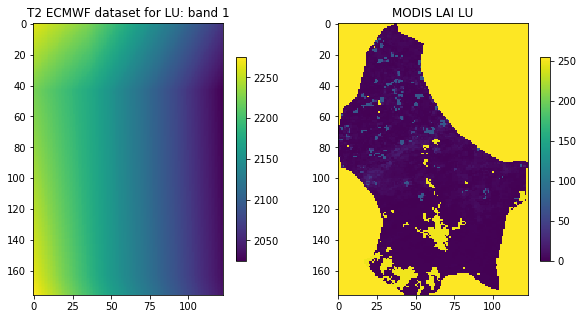

In [10]:
dst = gdal.GetDriverByName('MEM').Create('', wide, high, nbands, src_format)
dst.SetGeoTransform( match_geotrans )
dst.SetProjection( match_proj)

# Do the work: reproject the dataset
_ = gdal.ReprojectImage(src, dst, src_proj, match_proj, gdalconst.GRA_Bilinear)

'''
Visualise
'''
t2 = dst.GetRasterBand(1).ReadAsArray()
match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly).ReadAsArray()

# visualise
plt.figure(figsize=(10,5))
plt.subplot ( 1, 2, 1 )
plt.title(f'T2 ECMWF dataset for {country_code}: band 1')
plt.imshow(t2)
plt.colorbar(shrink=0.75)
plt.subplot ( 1, 2, 2 )
plt.title(f'MODIS LAI {country_code}')
plt.imshow(match_ds)
plt.colorbar(shrink=0.75)

### 3.6.3.5 crop

Finally, we crop the temperature dataset using `gdal.Warp()` and save it to a (GeoTiff) file:

In [11]:
 # Output / destination
dst_filename = src_filename.replace('.nc','.tif')
# get the no data value: -32767 here
frmat = 'GTiff'
g = gdal.Warp(dst_filename,
            dst,
            format=frmat,
            dstNodata=-32767,
            cutlineDSName=shpfile,
            cutlineWhere=f"FIPS='{country_code:s}'",
            cropToCutline=True)
del dst # Flush
del g

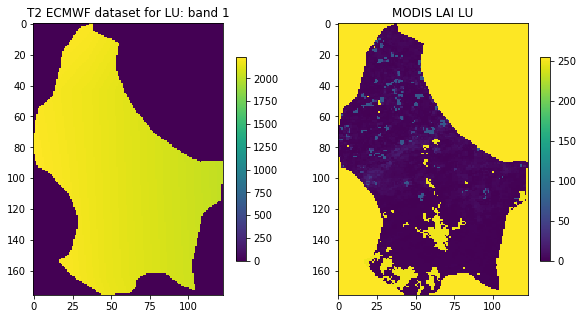

In [12]:
# visualise
t2 = gdal.Open(dst_filename, gdalconst.GA_ReadOnly)
t2 = t2.GetRasterBand(1).ReadAsArray()
match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly).ReadAsArray()

# visualise
plt.figure(figsize=(10,5))
plt.subplot ( 1, 2, 1 )
plt.title(f'T2 ECMWF dataset for {country_code}: band 1')
plt.imshow(t2,vmin=0)
plt.colorbar(shrink=0.75)
plt.subplot ( 1, 2, 2 )
plt.title(f'MODIS LAI {country_code}')
plt.imshow(match_ds)
plt.colorbar(shrink=0.75)

### 3.6.3.6 metadata

The netcdf file has metadata that we need to pay attention to.

In particular, we need to know 

* how to scale the data to physical units 
* how interpret the time units
* missing data value

In [13]:
meta = dict(src.GetMetadata())
print(meta.keys())

dict_keys(['latitude#long_name', 'latitude#units', 'longitude#long_name', 'longitude#units', 'NC_GLOBAL#Conventions', 'NC_GLOBAL#history', 'NETCDF_DIM_EXTRA', 'NETCDF_DIM_time_DEF', 'NETCDF_DIM_time_VALUES', 't2m#add_offset', 't2m#long_name', 't2m#missing_value', 't2m#scale_factor', 't2m#units', 't2m#_FillValue', 'time#calendar', 'time#long_name', 'time#units'])


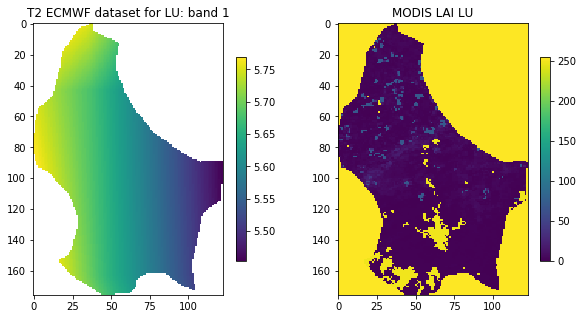

In [14]:
offset = float(meta['t2m#add_offset'])
scale = float(meta['t2m#scale_factor'])
missing = int(meta['t2m#missing_value'])

# set missing to nan
nodata = (t2 == missing)

# convert to C
temp2 = t2 * scale + offset - 273.15
temp2[nodata] = np.nan

# visualise
plt.figure(figsize=(10,5))
plt.subplot ( 1, 2, 1 )
plt.title(f'T2 ECMWF dataset for {country_code}: band 1')
plt.imshow(temp2)
plt.colorbar(shrink=0.75)
plt.subplot ( 1, 2, 2 )
plt.title(f'MODIS LAI {country_code}')
plt.imshow(match_ds)
plt.colorbar(shrink=0.75)

In [15]:
print(meta['time#units'])

hours since 1900-01-01 00:00:00.0


The time information is in hours since 1900-01-01 00:00:00.0. This is not such a convenient unit for plotting, so we can use `datetime` to fix that:


In [16]:
timer = meta['NETCDF_DIM_time_VALUES']
print(timer[:100])

{1016844,1016868,1016892,1016916,1016940,1016964,1016988,1017012,1017036,1017060,1017084,1017108,101


In [17]:
# split the string into integers
timer = [int(i) for i in meta['NETCDF_DIM_time_VALUES'][1:-1].split(',')]

print (timer[:20])

[1016844, 1016868, 1016892, 1016916, 1016940, 1016964, 1016988, 1017012, 1017036, 1017060, 1017084, 1017108, 1017132, 1017156, 1017180, 1017204, 1017228, 1017252, 1017276, 1017300]


In [18]:
# split the string into integers
# convert to days
timer = [float(i)/24. for i in meta['NETCDF_DIM_time_VALUES'][1:-1].split(',')]

print (timer[:20])

[42368.5, 42369.5, 42370.5, 42371.5, 42372.5, 42373.5, 42374.5, 42375.5, 42376.5, 42377.5, 42378.5, 42379.5, 42380.5, 42381.5, 42382.5, 42383.5, 42384.5, 42385.5, 42386.5, 42387.5]


In [19]:
from datetime import datetime,timedelta

# add base date
# split the string into integers
# convert to days
timer = [(datetime(1900,1,1) + timedelta(days=float(i)/24.)) \
         for i in meta['NETCDF_DIM_time_VALUES'][1:-1].split(',')]

print (timer[:20])

[datetime.datetime(2016, 1, 1, 12, 0), datetime.datetime(2016, 1, 2, 12, 0), datetime.datetime(2016, 1, 3, 12, 0), datetime.datetime(2016, 1, 4, 12, 0), datetime.datetime(2016, 1, 5, 12, 0), datetime.datetime(2016, 1, 6, 12, 0), datetime.datetime(2016, 1, 7, 12, 0), datetime.datetime(2016, 1, 8, 12, 0), datetime.datetime(2016, 1, 9, 12, 0), datetime.datetime(2016, 1, 10, 12, 0), datetime.datetime(2016, 1, 11, 12, 0), datetime.datetime(2016, 1, 12, 12, 0), datetime.datetime(2016, 1, 13, 12, 0), datetime.datetime(2016, 1, 14, 12, 0), datetime.datetime(2016, 1, 15, 12, 0), datetime.datetime(2016, 1, 16, 12, 0), datetime.datetime(2016, 1, 17, 12, 0), datetime.datetime(2016, 1, 18, 12, 0), datetime.datetime(2016, 1, 19, 12, 0), datetime.datetime(2016, 1, 20, 12, 0)]


## 3.6.4 Putting this together

We can now put these codes together to make a function `match_netcdf_to_data()`:

In [20]:
from osgeo import gdal, gdalconst,osr
import numpy as np
from geog0111.process_timeseries import mosaic_and_clip

def match_netcdf_to_data(src_filename,match_filename,dst_filename,\
                         country_code=country_code,shpfile=shpfile,\
                         nodata=-32767,frmat='GTiff',verbose=False):

    '''
    see :
    https://stackoverflow.com/questions/10454316/
    how-to-project-and-resample-a-grid-to-match-another-grid-with-gdal-python
    '''

    '''
    Get the projection, geotransform and dataset
    size that we want to match to
    '''
    if verbose: print(f'getting info from match file {match_filename}')
    match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly)
    match_proj = match_ds.GetProjection()
    match_geotrans = match_ds.GetGeoTransform()
    wide = match_ds.RasterXSize
    high = match_ds.RasterYSize
    # close the file -- we dont need it any more
    del match_ds

    '''
    access information from source
    '''
    if verbose: print(f'getting info from source netcdf file {src_filename}')
    try:
        src_dataname = 'NETCDF:"'+src_filename+'":t2m'
        src = gdal.Open(src_dataname, gdalconst.GA_ReadOnly)
    except:
        return(None)
    
    '''
    Get geotrans, data type and number of bands
    from source dataset
    '''
    band1 = src.GetRasterBand(1)
    src_geotrans = src.GetGeoTransform()
    nbands = src.RasterCount
    src_format = band1.DataType
    
    # try to get the src projection
    src_proj = src.GetProjection ()
    
    # if (when) we fail, tell it its wgs84
    if len(src_proj) == 0:
        # set up a spatial reference
        # as wgs84
        wgs84 = osr.SpatialReference ()
        wgs84.ImportFromEPSG ( 4326 )
        src_proj = wgs84.ExportToWkt()
        
    if verbose: print(f'setting transform and projection info')
    if shpfile:
        dst = gdal.GetDriverByName('MEM').Create(\
                                    '', wide, high, \
                                    nbands, src_format)
    else:
        dst = gdal.GetDriverByName(frmat).Create(\
                                    dst_filename, wide, high, \
                                    nbands, src_format)
        
    dst.SetGeoTransform( match_geotrans )
    dst.SetProjection( match_proj)

    # Do the work: reproject the dataset
    if verbose: print(f'reprojecting ...')
    _ = gdal.ReprojectImage(src, dst, src_proj, match_proj, gdalconst.GRA_Bilinear)

    if shpfile:
        if verbose: print(f'cropping to {country_code:s}...')
        # Output / destination
        gdal.Warp(dst_filename,
                    dst,
                    format=frmat,
                    dstNodata=nodata,
                    cutlineDSName=shpfile,
                    cutlineWhere=f"FIPS='{country_code:s}'",
                cropToCutline=True)
    if verbose: print(f'writing to {dst_filename}')
    del dst # Flush
    return(dst_filename)


def calibrate_t2(t2_filename,meta):
    '''
    apply scaling etc to temperature data t 2m
    '''
    # get time info
    timer = np.array([(datetime(1900,1,1) + timedelta(days=float(i)/24.)) \
         for i in meta['NETCDF_DIM_time_VALUES'][1:-1].split(',')])

    t2 = gdal.Open(dst_filename, gdalconst.GA_ReadOnly)
    t2 = np.array([t2.GetRasterBand(i+1).ReadAsArray() \
                   for i in range(timer.shape[0])])
    offset = float(meta['t2m#add_offset'])
    scale = float(meta['t2m#scale_factor'])
    missing = int(meta['t2m#missing_value'])
    # set missing to nan
    nodata = (t2 == missing)
    # convert to C
    temp2 = t2 * scale + offset - 273.15
    temp2[nodata] = np.nan
    return timer,temp2



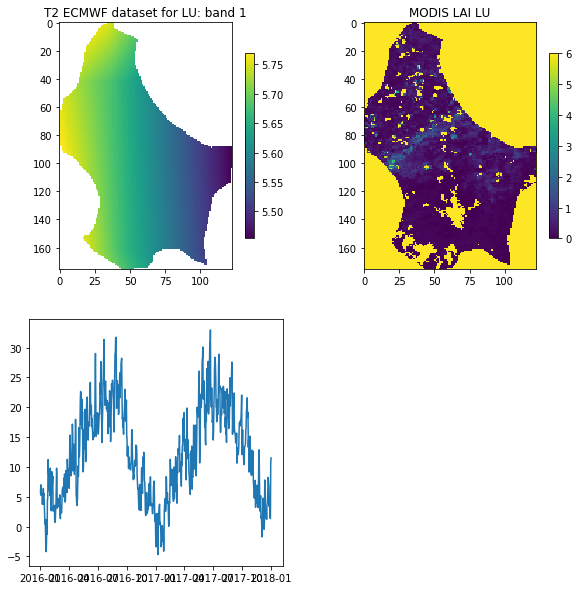

In [21]:
from osgeo import gdal, gdalconst,osr
import numpy as np
from geog0111.process_timeseries import mosaic_and_clip
from datetime import datetime,timedelta
from geog0111.match_netcdf_to_data import match_netcdf_to_data,calibrate_t2

# set conditions
country_code = 'LU'
shpfile = "data/TM_WORLD_BORDERS-0.3.shp"
src_filename = 'data/europe_data_2016_2017.nc'
dst_filename = f'data/europe_data_{country_code}_2016_2017.tif'

#read LAI
fname = f'lai_data_{year}_{country_code}.npz'
ofile = Path('data')/fname
lai = np.load(ofile)

# first get an exemplar LAI file, clipped to
# the required limits. We will use this to match  
# the t2 dataset to
match_filename = mosaic_and_clip(tiles,1,2017,\
                    country_code=country_code,shpfile=shpfile,frmat='GTiff')
'''
Match the datasets using the function
we have developed
'''
meta = gdal.Open(src_filename, gdalconst.GA_ReadOnly).GetMetadata()

match_netcdf_to_data(src_filename,match_filename,dst_filename,\
                         country_code=country_code,shpfile=shpfile,\
                         nodata=int(meta['t2m#missing_value']),\
                         frmat='GTiff',verbose=False)


# read and interpret the t2 data
timer,temp2 = calibrate_t2(dst_filename,meta)

match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly).ReadAsArray()

# visualise
plt.figure(figsize=(10,10))
plt.subplot ( 2, 2, 1 )
plt.title(f'T2 ECMWF dataset for {country_code}: band 1')
plt.imshow(temp2[0])
plt.colorbar(shrink=0.75)
plt.subplot ( 2, 2, 2 )
plt.title(f'MODIS LAI {country_code}')
plt.imshow(lai['lai'][:,:,0],vmax=6)
plt.colorbar(shrink=0.75)
plt.subplot ( 2, 2, 3 )
plt.plot(timer,np.nanmean(temp2,axis=(1,2)))

## 3.6.5 Movies

In [ ]:
from matplotlib import animation
import matplotlib.pylab as plt
from IPython.display import HTML

'''
lai movie javascript/html (jshtml)
'''

#fig, ax = plt.subplots(figsize=(10,10))
fig = plt.figure(0,figsize=(10,10))

# define an animate function
# with the argument i, the frame number
def animate(i):
    # show frame i of the ilai dataset
    plt.figure(0)
    im = plt.imshow(interpolated_lai[:,:,i],vmin=0,vmax=6,cmap=plt.cm.inferno_r)
    plt.title(f'{product} {FIPS} {params[0]} {year} DOY {4*i+1:03d}')
    # make sure to return a tuple!!
    return (im,)

# set up the animation  
anim = animation.FuncAnimation(fig, animate, 
                               frames=interpolated_lai.shape[2], interval=40, 
                               blit=True)     

# display animation as HTML
HTML(anim.to_jshtml())